# **Importación de librerías y configuración inicial**

En este bloque se realiza la importación de las librerías necesarias para el análisis y modelado de datos. Estas librerías incluyen:

- `pandas` para la manipulación de datos.
- `scikit-learn` para la construcción de pipelines, preprocesamiento, y modelado con clasificadores como `RandomForestClassifier` y `GradientBoostingClassifier`.
- `xgboost` para el modelo de clasificación basado en boosting.
- `matplotlib.pyplot` para la visualización.
- `scipy.stats.boxcox` para aplicar transformaciones de Box-Cox a los datos.
- Utilidades adicionales como `GridSearchCV` y `RandomizedSearchCV` para la optimización de hiperparámetros.

También se configura una semilla (`SEED`) para garantizar la reproducibilidad de los resultados.

Este bloque establece las bases necesarias para los pasos posteriores del análisis y modelado.


In [191]:
# --- Manejo de datos ---
import pandas as pd  # Para manipulación y análisis de datos
import numpy as np  # Para operaciones matemáticas y manejo de arrays

# --- Preprocesamiento de datos ---
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Para escalado y codificación de etiquetas
from sklearn.utils import resample  # Para oversampling clásico
from scipy.stats import boxcox  # Para transformación Box-Cox

# --- Construcción de pipelines y transformaciones ---
from sklearn.pipeline import Pipeline  # Para construir pipelines
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin  # Para crear estimadores personalizados

# --- Modelos ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Modelos de ensamble
from xgboost import XGBClassifier  # Modelo XGBoost
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística

# --- Evaluación de modelos ---
from sklearn.metrics import f1_score  # Métrica F1 para evaluar el rendimiento
from sklearn.model_selection import train_test_split  # Para dividir los datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Para búsqueda de hiperparámetros
from sklearn.model_selection import StratifiedKFold  # Validación cruzada estratificada

# --- Visualización ---
import matplotlib.pyplot as plt  # Para visualización de datos

# --- Configuración de la semilla ---
SEED = 42  # Fijar semilla para reproducibilidad
np.random.seed(SEED)  # Semilla para NumPy

# --- Mensaje de éxito ---
print("Librerías importadas correctamente y semilla ajustada.")


Librerías importadas correctamente y semilla ajustada.


# **Clases personalizadas para preprocesamiento y modelado**


En este bloque se implementan diversas clases personalizadas que forman parte del pipeline de preprocesamiento y modelado. Estas clases están diseñadas como transformadores compatibles con `scikit-learn`, permitiendo integrarlas fácilmente en pipelines.

1. **RemoveDuplicates**: 
   - Elimina registros duplicados del dataset.
   - No requiere entrenamiento.

2. **HandleOutliers**:
   - Maneja valores atípicos (`outliers`) mediante:
     - Limitación superior (capped) para la columna `density`.
     - Eliminación de outliers en `total_sulfur_dioxide` usando el método IQR.
   - Incluye opciones para desactivar este paso y personalizar el límite de `density`.

3. **FeatureTransformations**:
   - Aplica transformaciones específicas en las características del dataset, como:
     - Transformaciones logarítmicas y raíz cuadrada para reducir la variabilidad.
     - Estandarización de `citric_acid` usando `StandardScaler`.
     - Transformación de Box-Cox en columnas como `chlorides` y `sulphates`.

4. **FeatureCombinations**:
   - Genera nuevas características combinando columnas existentes, por ejemplo:
     - Relación `alcohol/density`.
     - Relación `free_sulfur_dioxide/total_sulfur_dioxide`.
     - Identificador binario si `citric_acid` es cero.
   - Permite eliminar las columnas originales tras crear las combinaciones.

5. **SklearnXGBClassifier**:
   - Corrige incompatibilidades entre `XGBoost` y versiones más recientes de `scikit-learn`.
   - Implementa métodos como `fit`, `predict` y `predict_proba` para garantizar compatibilidad con pipelines y validaciones cruzadas.

Estas clases personalizadas permiten un manejo flexible y escalable de los datos, facilitando el preprocesamiento y la construcción de modelos.

In [192]:
# Clase personalizada para eliminar duplicados
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    """
    Esta clase elimina duplicados del dataset.
    """
    def fit(self, X, y=None):
        # No necesita entrenamiento, simplemente devuelve self
        return self
    
    def transform(self, X):
        # Elimina los duplicados del dataset y devuelve los datos procesados
        return X.drop_duplicates()

# Clase personalizada para manejar los outliers
class HandleOutliers(BaseEstimator, TransformerMixin):
    """
    Esta clase maneja los outliers:
    - Aplica un capped (límite) a 'density'.
    - Elimina 'total sulfur dioxide'.
    - Mantiene 'chlorides' intacto.
    """
    def __init__(self, active=True, density_cap=1.05):
        """
        - active: Activa/desactiva el manejo de outliers.
        - density_cap: Límite superior para 'density'.
        """
        self.active = active
        self.density_cap = density_cap

    def fit(self, X, y=None):
        # No necesita entrenamiento, solo devuelve self
        return self

    def transform(self, X):
        # Si el bloque está desactivado, devolvemos X sin cambios
        if not self.active:
            return X
        
        # Hacemos una copia del dataset para evitar modificar el original
        X = X.copy()
        
        # Aplicamos el capped a 'density'
        if 'density' in X.columns:
            X['density'] = X['density'].clip(upper=self.density_cap)
        
        # Eliminamos outliers de 'total sulfur dioxide' usando IQR
        if 'total_sulfur_dioxide' in X.columns:
            q1 = X['total_sulfur_dioxide'].quantile(0.25)
            q3 = X['total_sulfur_dioxide'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            X = X[(X['total_sulfur_dioxide'] >= lower_bound) & (X['total_sulfur_dioxide'] <= upper_bound)]
        
        # No tocamos 'chlorides'
        return X

# Clase personalizada para transformar las características
class FeatureTransformations(BaseEstimator, TransformerMixin):
    """
    Clase para realizar transformaciones específicas en las columnas.
    """
    def __init__(self, scale=False):
        self.scale = scale
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if self.scale:
            # Ajustamos el escalador a todas las columnas numéricas excepto 'quality' y 'quality_encoded'
            self.numeric_columns = [col for col in X.columns if X[col].dtype in ['float64', 'int64'] \
                                    and col not in ['quality', 'quality_encoded']]
            self.scaler.fit(X[self.numeric_columns])
        return self

    def transform(self, X):
        X = X.copy()

        # Aplicamos las transformaciones específicas
        if 'fixed_acidity' in X.columns:
            X['fixed_acidity'] = np.log1p(X['fixed_acidity'])  # Logaritmo 1p
        if 'volatile_acidity' in X.columns:
            X['volatile_acidity'] = np.sqrt(X['volatile_acidity'])  # Raíz cuadrada
        if 'residual_sugar' in X.columns:
            X['residual_sugar'] = np.log1p(X['residual_sugar'])  # Logaritmo 1p
        if 'chlorides' in X.columns:
            X['chlorides'], _ = boxcox(X['chlorides'] + 1e-6)  # Box-Cox (evitamos ceros sumando un pequeño valor)
        if 'sulphates' in X.columns:
            X['sulphates'], _ = boxcox(X['sulphates'] + 1e-6)  # Box-Cox (igual que antes)

        # Escalado opcional de todas las columnas numéricas
        if self.scale:
            X[self.numeric_columns] = self.scaler.transform(X[self.numeric_columns])

        return X

class FeatureCombinations(BaseEstimator, TransformerMixin):
    """
    Clase para generar combinaciones de variables y eliminar las originales.
    """
    def fit(self, X, y=None):
        # No necesitamos calcular nada, devolvemos self
        return self

    def transform(self, X):
        X = X.copy()
        
        # Crear nueva variable: alcohol / density
        if 'alcohol' in X.columns and 'density' in X.columns:
            X['alcohol_density_ratio'] = X['alcohol'] / X['density']
        
        # Crear nueva variable: free sulfur dioxide / total sulfur dioxide
        if 'free_sulfur_dioxide' in X.columns and 'total_sulfur_dioxide' in X.columns:
            X['sulfur_ratio'] = X['free_sulfur_dioxide'] / X['total_sulfur_dioxide']
        
        # Crear nueva variable: citric0
        if 'citric acid' in X.columns:
            X['citric_is_zero'] = (X['citric_acid'] == 0).astype(int)
        
        # Eliminar columnas originales
        columns_to_drop = ['alcohol', 'density', 'free_sulfur_dioxide', 'total_sulfur_dioxide']
        # X = X.drop(columns=[col for col in columns_to_drop if col in X.columns])
        
        return X
    
# CLase para fix la incompatibilidad de XGBoost con Scikit-learn 1.6



class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)
        self.classes_ = None  # Inicializamos el atributo classes_

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        self.classes_ = self.model.classes_  # Asignamos las clases tras el entrenamiento
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

# **Funciones personalizadas para oversampling y evaluación de modelos**


En este bloque se implementan dos funciones personalizadas para mejorar el manejo de desequilibrios en las clases y la evaluación de modelos:

1. **oversample_data**:
   - Realiza *oversampling* clásico duplicando las instancias de las clases minoritarias en el conjunto de datos.
   - Se combinan las características (`X`) y el objetivo (`y`) en un solo DataFrame para realizar el muestreo, y luego se separan nuevamente.
   - Esta función es útil para equilibrar las clases antes de entrenar los modelos.

2. **probar_modelo_con_grid**:
   - Entrena un modelo utilizando `GridSearchCV`, que realiza una búsqueda exhaustiva de hiperparámetros.
   - Acepta un parámetro `modo` para seleccionar diferentes estrategias de balanceo de clases:
     - **oversampling**: Realiza *oversampling* antes de entrenar.
     - **balance**: Asigna pesos a las clases según su frecuencia en el conjunto de entrenamiento.
     - **ninguno**: No se realiza ninguna estrategia adicional.
   - Devuelve la puntuación F1 ponderada, los mejores parámetros encontrados y el mejor modelo.

3. **probar_modelo_con_random_search**:
   - Similar a la función anterior, pero usa `RandomizedSearchCV` para probar combinaciones aleatorias de parámetros.
   - Acepta el mismo parámetro `modo` para realizar *oversampling* o balanceo según sea necesario.
   - Devuelve la puntuación F1 ponderada, los mejores parámetros y el mejor modelo.

Estas funciones permiten una búsqueda eficiente de los mejores modelos mientras manejan desequilibrios en las clases de manera flexible.

In [193]:
def oversample_data(X, y):
    """
    Realiza oversampling clásico duplicando registros de clases minoritarias.
    """
    # Combinamos X e y en un solo dataframe temporal
    data = pd.concat([X, y], axis=1)
    target_col = y.name  # Guardamos el nombre de la columna objetivo

    # Encontramos la clase mayoritaria
    max_count = data[target_col].value_counts().max()

    # Aplicamos oversampling duplicando las clases minoritarias
    data_resampled = pd.DataFrame()
    for clase in data[target_col].unique():
        clase_data = data[data[target_col] == clase]
        clase_upsampled = resample(clase_data, replace=True, n_samples=max_count, random_state=SEED)
        data_resampled = pd.concat([data_resampled, clase_upsampled])
    
    # Separamos X e y de nuevo
    X_resampled = data_resampled.drop(target_col, axis=1)
    y_resampled = data_resampled[target_col]
    return X_resampled, y_resampled

# Ajustamos la función de modelos para usar el nuevo oversampling
def probar_modelo_con_grid(modelo, X_train, y_train, X_test, y_test, param_grid, modo="ninguno"):
    """
    Entrena y evalúa un modelo con búsqueda de hiperparámetros.
    - modelo: Modelo a entrenar.
    - X_train, y_train: Datos de entrenamiento.
    - X_test, y_test: Datos de prueba.
    - param_grid: Diccionario con los parámetros para GridSearch.
    - modo: Puede ser 'oversampling', 'balance' o 'ninguno'.
    """
    sample_weight = None

    if modo == "oversampling":
        X_train, y_train = oversample_data(X_train, y_train)

    elif modo == "balance":
        class_weights = {cls: len(y_train) / (len(set(y_train)) * sum(y_train == cls)) for cls in set(y_train)}
        sample_weight = y_train.map(class_weights) if hasattr(y_train, 'map') else [class_weights[cls] for cls in y_train]

    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    grid_search = GridSearchCV(
        modelo,
        param_grid,
        scoring='f1_weighted',
        cv=stratified_cv,
        n_jobs=-1,
        error_score='raise',
        random_state=SEED
    )

    if sample_weight is not None:
        grid_search.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1, grid_search.best_params_, best_model

def probar_modelo_con_random_search(modelo, X_train, y_train, X_test, y_test, param_distributions, n_iter=50, modo="ninguno"):
    """
    Entrena y evalúa un modelo con búsqueda aleatoria de hiperparámetros.
    - modelo: Modelo a entrenar.
    - X_train, y_train: Datos de entrenamiento.
    - X_test, y_test: Datos de prueba.
    - param_distributions: Diccionario con las distribuciones de parámetros para RandomizedSearch.
    - n_iter: Número de combinaciones a probar.
    - modo: Puede ser 'oversampling', 'balance' o 'ninguno'.
    """
    sample_weight = None

    if modo == "oversampling":
        X_train, y_train = oversample_data(X_train, y_train)

    elif modo == "balance":
        class_weights = {cls: len(y_train) / (len(set(y_train)) * sum(y_train == cls)) for cls in set(y_train)}
        sample_weight = y_train.map(class_weights) if hasattr(y_train, 'map') else [class_weights[cls] for cls in y_train]

    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    # Configuramos RandomizedSearch
    random_search = RandomizedSearchCV(
        modelo,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Número de combinaciones a probar
        scoring='f1_weighted',
        cv=stratified_cv,
        n_jobs=-1,
        random_state=SEED,
        error_score='raise'
        
    )

    # Entrenamos con sample_weight si es necesario
    if sample_weight is not None:
        random_search.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        random_search.fit(X_train, y_train)

    # Usamos el mejor modelo encontrado
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1, random_search.best_params_, best_model


### Resultados esperados
Las funciones de evaluación (`GridSearchCV` y `RandomizedSearchCV`) devolverán los siguientes resultados:

- **Puntuación F1 ponderada**: La métrica de evaluación usada para evaluar el rendimiento del modelo considerando el balance entre precisión y recall en clases desbalanceadas.
- **Mejores parámetros**: Los mejores parámetros encontrados por las búsquedas de hiperparámetros (ya sea por *grid search* o *random search*).
- **Mejor modelo**: El modelo entrenado con los mejores parámetros.

El *oversampling* y las estrategias de balanceo de clases ayudarán a mejorar la precisión en clases minoritarias, lo que se reflejará en una puntuación F1 más alta.


# **Carga y balanceo del dataset**


En este bloque, se carga el conjunto de datos de vinos desde un archivo CSV y se realiza un balanceo de clases mediante duplicación.

1. **Carga del dataset**: 
   - Usamos `pandas.read_csv` para cargar los datos desde un archivo CSV (`wine_quality.csv`) y guardarlos en un DataFrame (`df`).

2. **Distribución inicial de clases**:
   - Mostramos la distribución de la variable objetivo `quality` antes de aplicar cualquier técnica de balanceo para observar el número de muestras por clase.

3. **Duplicación de clases minoritarias**:
   - Identificamos las clases que tienen menos de 10 registros (`min_registros = 10`).
   - Para cada clase con pocos registros, duplicamos las filas de esa clase hasta alcanzar el mínimo de 10 registros.
   - La duplicación se realiza de manera automática y se utiliza `pandas.concat` para agregar las filas repetidas al DataFrame original.

4. **Distribución de clases después de duplicar**:
   - Se recalcula y muestra la distribución de clases después de realizar la duplicación, permitiendo observar el efecto de esta estrategia de balanceo.

Este proceso ayuda a asegurar que todas las clases tengan al menos un número mínimo de registros antes de entrenar los modelos, lo que puede mejorar la calidad de los resultados.


In [194]:
# Cargar dataset
# Aquí reemplaza 'ruta_dataset.csv' con la ubicación de tu dataset
ruta_dataset = 'wine_quality.csv'
df = pd.read_csv(ruta_dataset)


# Mostrar la distribución de valores inicial
print("Distribución de valores por clase antes de duplicar:")
distribucion_clases = df['quality'].value_counts().sort_index()
print(distribucion_clases)

# Duplicar automáticamente clases con menos de 10 registros
min_registros = 10
for clase, conteo in distribucion_clases.items():
    if conteo < min_registros:
        # Filtrar las filas de la clase con pocos registros
        df_clase = df[df['quality'] == clase]
        # Calcular cuántas veces hay que duplicar para alcanzar el mínimo
        veces_duplicar = (min_registros - conteo) // conteo + 1
        # Duplicar y concatenar
        df = pd.concat([df] + [df_clase] * veces_duplicar)

# Recalcular y mostrar la distribución de valores actualizada
print("Distribución de valores por clase después de duplicar:")
distribucion_clases_actualizada = df['quality'].value_counts().sort_index()
print(distribucion_clases_actualizada)


Distribución de valores por clase antes de duplicar:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64
Distribución de valores por clase después de duplicar:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9      15
Name: count, dtype: int64


### Resultados de la carga y duplicación del dataset

Tras cargar y procesar los datos, observamos lo siguiente:

- **Distribución de valores por clase antes de duplicar**:
  - La clase `9` tenía solo 5 registros, lo que es insuficiente para el modelado.
  - Otras clases tienen una distribución bastante balanceada, con más registros en clases como `6` y `5`.

- **Distribución de valores por clase después de duplicar**:
  - Después de duplicar las clases con menos de 10 registros, la clase `9` se ha incrementado a 15 registros, alcanzando el mínimo de 10 establecido.
  - Las demás clases no se vieron afectadas, ya que su número de registros ya era suficiente.

Este proceso de duplicación ayuda a equilibrar las clases y garantizar que todas tengan suficientes ejemplos para entrenar modelos de clasificación.


# **Aplicación de Label Encoding al target**

En este bloque se aplica el proceso de *Label Encoding* a la variable objetivo `quality`. El *Label Encoding* es una técnica de preprocesamiento que convierte las categorías de una columna en valores numéricos, lo cual es necesario para que los modelos de machine learning puedan trabajar con ellas.

1. **Label Encoding**:
   - Se utiliza `LabelEncoder` de `scikit-learn` para transformar la variable categórica `quality` en valores numéricos.
   - La transformación asigna un número entero a cada clase de la variable `quality`, y el resultado se guarda en una nueva columna llamada `quality_encoded`.

Este paso es crucial para convertir las etiquetas de clase (que inicialmente son valores como `3`, `4`, `5`, etc.) en un formato que los modelos puedan manejar.

In [195]:
# Aplicar Label Encoding al target
label_encoder = LabelEncoder()
df['quality_encoded'] = label_encoder.fit_transform(df['quality'])


### Resultados de Label Encoding

Después de aplicar *Label Encoding*, la columna `quality_encoded` contiene las representaciones numéricas de las clases en la columna `quality`. Por ejemplo, si la clase `3` fue codificada como `0`, `4` como `1`, y así sucesivamente.

Este paso convierte las etiquetas en una forma numérica que los modelos de aprendizaje automático pueden usar, facilitando el proceso de entrenamiento y evaluación.


# **Configuración de modelos**




En este bloque se configuran los modelos de clasificación que se utilizarán en el análisis:

1. **Random Forest**:
   - Se crea una instancia del clasificador `RandomForestClassifier` con una semilla aleatoria para garantizar la reproducibilidad.

2. **Gradient Boosting**:
   - Se crea una instancia del clasificador `GradientBoostingClassifier`, también con la semilla aleatoria establecida para asegurar que los resultados sean consistentes.

3. **XGBoost**:
   - Se configuran dos opciones para `XGBoost`:
     - La opción comentada con la línea original (`XGBClassifier`) en caso de que haya problemas con la versión de `XGBoost`.
     - La opción activa usa `SklearnXGBClassifier`, que resuelve posibles incompatibilidades con `scikit-learn`.

Estos clasificadores se usarán para entrenar el modelo y realizar predicciones sobre los datos.

In [196]:
modelos = {
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED) # Si falla, usar esta linea
    "XGBoost": SklearnXGBClassifier(eval_metric='logloss', random_state=SEED) # Si falla, usar esta linea
}

# **Configuración de los parámetros para la búsqueda de hiperparámetros (Random Search)**

En este bloque se definen los rangos de parámetros que se explorarán durante la búsqueda de hiperparámetros para cada uno de los modelos de clasificación.

1. **Random Forest** (`param_distributions_rf`):
   - **`n_estimators`**: Número de árboles en el bosque (50, 100, 150).
   - **`max_depth`**: Profundidad máxima de los árboles para controlar el sobreajuste (10, 15, 20).
   - **`min_samples_split`**: Número mínimo de muestras necesarias para dividir un nodo (2, 4, 8).
   - **`min_samples_leaf`**: Número mínimo de muestras necesarias para estar en una hoja (1, 2).

2. **Gradient Boosting** (`param_distributions_gb`):
   - **`n_estimators`**: Número de estimadores (50, 100, 150).
   - **`learning_rate`**: Tasa de aprendizaje para el ajuste de los árboles (0.1, 0.05, 0.01).
   - **`max_depth`**: Profundidad máxima de cada árbol en el modelo boosting (3, 4, 5).
   - **`subsample`**: Proporción de muestras utilizadas para entrenar cada árbol (0.8, 1.0).

3. **XGBoost** (`param_distributions_xgb`):
   - **`n_estimators`**: Número de estimadores (50, 100, 150).
   - **`learning_rate`**: Tasa de aprendizaje (0.1, 0.05, 0.01).
   - **`max_depth`**: Profundidad máxima de los árboles (3, 4, 5).
   - **`subsample`**: Proporción de muestras utilizadas por árbol (0.8, 1.0).
   - **`colsample_bytree`**: Proporción de características usadas por cada árbol (0.7, 1.0).
   - **`lambda`**: Regularización L2 (1, 10).
   - **`alpha`**: Regularización L1 (0.1, 1).

Estos parámetros se utilizarán en la búsqueda de hiperparámetros para optimizar el rendimiento de cada modelo.

In [197]:
param_distributions_rf = {
    "n_estimators": [50, 100, 150],  # Reducimos el rango pero mantenemos opciones razonables
    "max_depth": [10, 15, 20],      # Limitar a profundidades clave
    "min_samples_split": [2, 4, 8], # Opciones comunes para reducir overfitting
    "min_samples_leaf": [1, 2],     # Añadimos este parámetro porque puede impactar en datasets pequeños
}


param_distributions_gb = {
    "n_estimators": [50, 100, 150],       # Valores que evitan sobreentrenar rápidamente
    "learning_rate": [0.1, 0.05, 0.01],  # Rango más pequeño pero suficiente para explorar ajustes
    "max_depth": [3, 4, 5],              # Valores típicos en boosting
    "subsample": [0.8, 1.0],             # Control de muestra para evitar overfitting
}


param_distributions_xgb = {
    "n_estimators": [50, 100, 150],          # Reducido a valores prácticos
    "learning_rate": [0.1, 0.05, 0.01],     # Similares a Gradient Boosting
    "max_depth": [3, 4, 5],                 # Foco en valores eficientes
    "subsample": [0.8, 1.0],                # Fracción de datos a usar por iteración
    "colsample_bytree": [0.7, 1.0],         # Número de características por árbol
    "lambda": [1, 10],                      # Regularización L2 básica
    "alpha": [0.1, 1],                      # Regularización L1 para sparsity
}



# **Configuración de los parámetros para la búsqueda de hiperparámetros (Grid Search)**



En este bloque se definen los parámetros de búsqueda que se utilizarán en la función de `GridSearchCV` para cada modelo, especificando los rangos de valores para optimizar durante la búsqueda.

1. **Random Forest** (`param_grids["Random Forest"]`):
   - **`n_estimators`**: Número de árboles en el bosque (100, 200).
   - **`max_depth`**: Profundidad máxima de los árboles (ninguna o 10).
   - **`min_samples_split`**: Número mínimo de muestras necesarias para dividir un nodo (2, 5).
   - **`min_samples_leaf`**: Número mínimo de muestras necesarias para estar en una hoja (1, 2).

2. **Gradient Boosting** (`param_grids["Gradient Boosting"]`):
   - **`n_estimators`**: Número de iteraciones (100, 200).
   - **`learning_rate`**: Tasa de aprendizaje para ajustar la influencia de cada árbol (0.01, 0.1).
   - **`max_depth`**: Profundidad máxima de los árboles (3, 5).

3. **XGBoost** (`param_grids["XGBoost"]`):
   - **`n_estimators`**: Número de iteraciones (100, 200).
   - **`learning_rate`**: Tasa de aprendizaje (0.05, 0.1).
   - **`max_depth`**: Profundidad máxima de los árboles (3, 5).
   - **`gamma`**: Penalización por la complejidad del modelo (0, 1).
   - **`lambda`**: Regularización L2 (1).
   - **`alpha`**: Regularización L1 (0.1, 1.0).

Estos parámetros serán utilizados en la búsqueda de hiperparámetros mediante `GridSearchCV` para encontrar la combinación óptima que maximice el rendimiento del modelo.


In [198]:
# Configuración de grids
param_grids = {
    "Random Forest": {
    "n_estimators": [100, 200],             # Solo 2 valores para el número de árboles
    "max_depth": [None, 10],               # Profundidad máxima
    "min_samples_split": [2, 5],           # División mínima
    "min_samples_leaf": [1, 2]             # Número mínimo de muestras por hoja
},

    "Gradient Boosting": {
    "n_estimators": [100, 200],            # Número de iteraciones
    "learning_rate": [0.01, 0.1],          # Tasas de aprendizaje más comunes
    "max_depth": [3, 5]                    # Profundidad máxima                 
},

   "XGBoost": {
    "n_estimators": [100, 200],            # Número de iteraciones
    "learning_rate": [0.05, 0.1],          # Tasas de aprendizaje
    "max_depth": [3, 5],                   # Profundidad máxima
    "gamma": [0, 1],                       # Penalización por nodos adicionales
    "lambda": [1],                         # Regularización L2 (valor fijo razonable)
    "alpha": [0.1, 1.0]                    # Regularización L1
}

}

# Construccion del pipeline

## Construcción del Pipeline

En este bloque se construye el *pipeline* para el preprocesamiento de los datos antes de entrenar el modelo. El *pipeline* permite encadenar múltiples pasos de procesamiento y aplicar las transformaciones de manera secuencial.

1. **Paso 1: Eliminar Duplicados** (comentado):
   - Se ha desactivado esta parte del *pipeline* ya que su aplicación empeoraba el rendimiento del modelo. Sin embargo, esta fase podría ser útil en otros escenarios donde los duplicados sean problemáticos.

2. **Paso 2: Tratamiento de Outliers**:
   - Se utiliza la clase `HandleOutliers`, que maneja los valores atípicos mediante la aplicación de un límite superior a la columna `density` y la eliminación de outliers en `total_sulfur_dioxide` usando el rango intercuartílico (IQR).
   - Este paso ayuda a prevenir que los outliers distorsionen el entrenamiento del modelo.
   - Se puede activar o desactivar este paso cambiando active=True por False

3. **Paso 3: Transformación de Características**:
   - Se usa la clase `FeatureTransformations` para realizar transformaciones específicas en varias columnas del dataset, como la aplicación de logaritmos y Box-Cox, así como la estandarización de `citric_acid`.
   - Estas transformaciones pueden mejorar la capacidad del modelo para aprender patrones relevantes.

4. **Paso 4: Combinación de Características** (comentado):
   - Se ha desactivado esta fase debido a que perjudicaba el análisis, pero la clase `FeatureCombinations` permite crear nuevas variables combinando las existentes, lo que puede mejorar el rendimiento del modelo en algunos casos.

Este *pipeline* se asegura de que las transformaciones y manipulaciones de los datos se realicen de manera coherente y eficiente antes de entrenar el modelo.


In [199]:


pipeline = Pipeline(steps=[
    #('Paso 1: Eliminar Duplicados', RemoveDuplicates()),  # Desactivado - Empeora el resultado
    ('Paso 2: Tratamiento Outliers', HandleOutliers(active=False, density_cap=1.05)),  # Paso 2: manejar outliers
    ('Paso 3: Transformación de características', FeatureTransformations(scale=False)),  # Paso 3: transformaciones específicas
    #('Paso 4: Combinación de características', FeatureCombinations()),  # Paso 5: combinaciones de variables
])




# **Aplicación del Pipeline**

En este bloque, aplicamos el *pipeline* que hemos construido previamente al conjunto de datos `df`. La función `fit_transform()` se utiliza para ajustar y transformar el dataset en un solo paso.

1. **`fit_transform(df)`**:
   - El método `fit_transform()` realiza dos tareas:
     - **Fit**: Ajusta todos los pasos del *pipeline* a los datos de entrada (`df`), es decir, calcula las estadísticas necesarias para las transformaciones (por ejemplo, para la estandarización o la detección de outliers).
     - **Transform**: Aplica las transformaciones calculadas durante el ajuste a los datos, devolviendo el dataset procesado.
   
2. **Resultado**:
   - El resultado es el DataFrame `df_procesado`, que contiene los datos después de haber pasado por todos los pasos definidos en el *pipeline* (manejo de outliers y transformaciones de características).

Este paso prepara los datos para ser utilizados en el entrenamiento de los modelos.


In [200]:
# Aplicamos el pipeline
df_procesado = pipeline.fit_transform(df)


### Resultados esperados

Tras aplicar el *pipeline* con `fit_transform()`, obtenemos el DataFrame `df_procesado`, que contiene las siguientes transformaciones:
  
- Los outliers han sido manejados según los parámetros establecidos.
- Las características han sido transformadas, incluyendo logaritmos, Box-Cox y estandarización, según corresponda.

Este conjunto de datos procesado está listo para ser utilizado en el entrenamiento de modelos de machine learning.


# **División del Dataset en Entrenamiento y Prueba**



En este bloque se divide el dataset procesado en dos conjuntos: uno para entrenar los modelos y otro para evaluarlos. Usamos la función `train_test_split` de `scikit-learn` para realizar esta partición.

1. **Definición de variables**:
   - **`X`**: Contiene las características del dataset, excluyendo las columnas `quality_encoded` y `quality`, que son la variable objetivo.
   - **`y`**: Contiene la variable objetivo, que es la columna `quality_encoded`, que ya ha sido codificada numéricamente.

2. **División en conjunto de entrenamiento y prueba**:
   - Usamos `train_test_split(X, y, test_size=0.2, random_state=SEED)` para dividir los datos en un 80% para entrenamiento y un 20% para prueba. Esto garantiza que el modelo se entrene con una gran parte de los datos y se evalúe con un conjunto independiente para comprobar su rendimiento.
   - **`random_state=SEED`** asegura que la división sea reproducible.


In [201]:
# Dividimos en entrenamiento y prueba
X = df_procesado.drop(['quality_encoded','quality'], axis=1)  
y = df_procesado['quality_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)




### Resultados esperados

Este bloque no genera resultados inmediatos, pero la división de los datos crea cuatro variables:
- **`X_train`**: Conjunto de entrenamiento con las características.
- **`X_test`**: Conjunto de prueba con las características.
- **`y_train`**: Conjunto de entrenamiento con la variable objetivo.
- **`y_test`**: Conjunto de prueba con la variable objetivo.

Estas variables se usarán para entrenar los modelos y luego evaluar su rendimiento en el conjunto de prueba.


# **Prueba de Modelos con Búsqueda de Hiperparámetros**

En este bloque, se entrenan y evalúan los modelos utilizando **Grid Search** o **Random Search** para encontrar la mejor combinación de hiperparámetros. La elección de la búsqueda se define en la variable `search_method`.

Ene esta parte se introducen todas las variables a los modelo.

1. **Configuración de búsqueda**:
   - Se prueba cada modelo con diferentes estrategias de balanceo de clases (`balance`, `ninguno`).
   - Dependiendo de la elección de `search_method`, se utiliza:
     - **Grid Search** (`GridSearchCV`): Realiza una búsqueda exhaustiva de todos los parámetros definidos en `param_grids`.
     - **Random Search** (`RandomizedSearchCV`): Realiza una búsqueda aleatoria sobre los parámetros definidos en `param_distributions` para cada modelo.

2. **Proceso de evaluación**:
   - Para cada modelo, se ajustan los hiperparámetros usando las funciones `probar_modelo_con_grid` o `probar_modelo_con_random_search`, y se evalúan con la métrica `F1-Weighted`.
   - Los resultados, que incluyen el rendimiento del modelo y los mejores hiperparámetros, se almacenan en la lista `resultados`.

3. **Selección del mejor modelo**:
   - Al final del proceso, el modelo con el mejor `F1-Weighted` se identifica y se guarda como el modelo ganador.
   - El modelo ganador es el que tiene la mejor puntuación en el conjunto de datos de prueba, considerando los hiperparámetros óptimos encontrados.

Este bloque permite encontrar el modelo más adecuado para el conjunto de datos a través de la optimización de hiperparámetros, ayudando a mejorar el rendimiento general del modelo.

In [202]:
# Resultados
resultados = []

# Modos a probar (oversampling, balance, ninguno)
modos = ["balance", "ninguno"]

search_method = "Random Search"  # Puedes cambiar a "Grid Search" si prefieres

if search_method == "Grid Search":
    print("Usando Grid Search...")

    # Probar cada modelo con Grid Search
    for nombre, modelo in modelos.items():
        param_grid = param_grids[nombre]  # Obtenemos el grid correspondiente
        for modo in modos:
            f1, best_params, best_model = probar_modelo_con_grid(
                modelo,
                X_train,
                y_train,
                X_test,
                y_test,
                param_grid=param_grid,
                modo=modo
            )
            resultados.append({
                "Modelo": nombre,
                "Modo": modo,
                "F1-Weighted": f1,
                "Mejores Hiperparámetros": best_params
            })



    # Identificar el modelo con mejor F1-Weighted
    mejor_modelo = max(resultados, key=lambda x: x['F1-Weighted'])
    nombre_modelo_ganador = mejor_modelo['Modelo']

    print(f"El modelo ganador es: {nombre_modelo_ganador}")
    # Guardamos el modelo ajustado
    modelos[nombre] = best_model


if search_method == "Random Search":

    # Probar cada modelo con Random Search
    for nombre, modelo in modelos.items():
        if nombre == "Random Forest":
            param_distributions = param_distributions_rf
        elif nombre == "XGBoost":
            param_distributions = param_distributions_xgb
        elif nombre == "Gradient Boosting":
            param_distributions = param_distributions_gb
        else:
            raise ValueError(f"Modelo no reconocido: {nombre}")
        
        for modo in modos:
            f1, best_params, best_model = probar_modelo_con_random_search(
                modelo,
                X_train,
                y_train,
                X_test,
                y_test,
                param_distributions=param_distributions,
                n_iter=50,  # Ajustable según los recursos
                modo=modo
            )
            resultados.append({
                "Modelo": nombre,
                "Modo": modo,
                "F1-Weighted": f1,
                "Mejores Hiperparámetros": best_params
            })

            # Identificar el modelo con mejor F1-Weighted
            mejor_modelo = max(resultados, key=lambda x: x['F1-Weighted'])
            nombre_modelo_ganador = mejor_modelo['Modelo']

            print(f"El modelo ganador es: {nombre_modelo_ganador}")
            # Guardamos el modelo ajustado
            modelos[nombre] = best_model



El modelo ganador es: Random Forest
El modelo ganador es: Random Forest
El modelo ganador es: Random Forest
El modelo ganador es: Random Forest
El modelo ganador es: Random Forest
El modelo ganador es: Random Forest


# **Entrenamiento y Evaluación del Modelo Baseline**

En este bloque se entrena y evalúa un modelo de referencia (*baseline*), sin aplicar las transformaciones del *pipeline*. Este modelo se utiliza para comparar el rendimiento de los modelos más avanzados que se probarán más tarde.

1. **Dataset para el Baseline**:
   - Se excluyen las columnas `quality` y `quality_encoded` para definir las características (`X_baseline`) y se utiliza la columna `quality_encoded` como la variable objetivo (`y_baseline`).
   
2. **División en conjunto de entrenamiento y prueba**:
   - Se divide el dataset en conjuntos de entrenamiento y prueba, usando un 80% para entrenamiento y un 20% para prueba. Esto se hace utilizando `train_test_split`, con la misma semilla para garantizar la reproducibilidad.

3. **Entrenamiento del modelo Baseline**:
   - Se entrena un modelo `XGBClassifier` sin utilizar *GridSearch* ni *RandomSearch*, con los parámetros predeterminados. El modelo es entrenado en el conjunto de entrenamiento (`X_train_base` y `y_train_base`).

4. **Evaluación del Baseline**:
   - Se realiza una predicción sobre el conjunto de prueba (`X_test_base`), y se calcula el `F1-Weighted`, que es la métrica utilizada para evaluar el rendimiento del modelo, considerando el balance entre precisión y recall en clases desbalanceadas.

5. **Registro de resultados**:
   - Los resultados de este modelo baseline, incluyendo la puntuación `F1-Weighted` y la indicación de que no se usó búsqueda de hiperparámetros, se añaden a la lista `resultados` para su comparación posterior con los otros modelos.

In [203]:
# Dataset para el baseline (sin pasar por el pipeline)
X_baseline = df.drop(['quality', 'quality_encoded'], axis=1)
y_baseline = df['quality_encoded']

# Dividir en entrenamiento y prueba
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=SEED
)

# Entrenar y evaluar el baseline
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
baseline_model.fit(X_train_base, y_train_base)
y_pred_base = baseline_model.predict(X_test_base)

# Calcular F1-Weighted
f1_baseline = f1_score(y_test_base, y_pred_base, average='weighted')

# Añadir a resultados
resultados.append({
    "Modelo": "Baseline XGBoost",
    "Modo": "Ninguno",
    "F1-Weighted": f1_baseline,
    "Mejores Hiperparámetros": "Sin GridSearch"
})


c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\xgboost\core.py:158: UserWarning: [17:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Resultados esperados

Este bloque calculará los siguientes resultados:

- **F1-Weighted**: El rendimiento del modelo baseline, que se espera que sirva como referencia para los modelos posteriores. 
- **Mejores Hiperparámetros**: En este caso, no se utilizaron búsquedas de hiperparámetros, por lo que el valor será "Sin GridSearch".

El modelo baseline proporciona un punto de partida para comparar los modelos que se optimizarán en los siguientes pasos.


# **Evaluación de Modelos y Visualización de Resultados**



En este bloque se organizan y muestran los resultados obtenidos de la prueba de los modelos. La métrica clave es el `F1-Weighted`, que evalúa el rendimiento de cada modelo considerando el balance entre precisión y recall.

1. **Creación de un DataFrame con los resultados**:
   - Se convierte la lista `resultados` en un DataFrame de `pandas` para facilitar la visualización.
   - El DataFrame contiene los resultados de los modelos probados, con las columnas: `Modelo`, `Modo`, `F1-Weighted`, y `Mejores Hiperparámetros`.

2. **Ordenación por `F1-Weighted`**:
   - Se ordenan los resultados por la puntuación `F1-Weighted` de manera descendente, de modo que el mejor modelo aparezca en la parte superior.

3. **Configuración de opciones de visualización**:
   - Se ajustan varias opciones de `pandas` para mostrar todas las filas, columnas, y datos sin que se corten, lo que permite ver todos los resultados en detalle.

4. **Mostrar los resultados**:
   - Finalmente, se muestra el DataFrame con todos los resultados utilizando `display(resultados_df)`.


In [204]:
# Mostrar resultados ordenados por f1-weighted
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by='F1-Weighted', ascending=False)
resultados_df = resultados_df.reset_index(drop=True)
# Mostrar todas las filas
pd.set_option('display.max_colwidth', None)
# Mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Mostrar todas las columnas
pd.set_option('display.width', None)
# Mostrar todos los resultados
pd.set_option('display.max_rows', None)
# Evitar que las columnas se corten
pd.set_option('display.expand_frame_repr', False)

display(resultados_df)  

,Modelo,Modo,F1-Weighted,Mejores Hiperparámetros
0,Random Forest,balance,0.687034,"{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}"
1,Random Forest,ninguno,0.681682,"{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}"
2,Baseline XGBoost,Ninguno,0.666304,Sin GridSearch
3,Gradient Boosting,ninguno,0.658129,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}"
4,Gradient Boosting,balance,0.641995,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}"
5,XGBoost,ninguno,0.603245,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'colsample_bytree': 0.7, 'alpha': 0.1}"
6,XGBoost,balance,0.555762,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'colsample_bytree': 0.7, 'alpha': 0.1}"


### Conclusiones de los Resultados

Tras la evaluación de los modelos, se pueden extraer las siguientes conclusiones basadas en la métrica `F1-Weighted`:

1. **Modelo con Mejor Rendimiento**:
   - El **Random Forest** con estrategia de balanceo (`balance`) alcanzó el mejor rendimiento con un `F1-Weighted` de **0.687034**. Este resultado indica que el balanceo de clases mejora la capacidad del modelo para manejar desequilibrios en los datos.

2. **Comparación del Random Forest**:
   - El Random Forest sin balanceo (`ninguno`) obtuvo un puntaje ligeramente inferior de **0.681682**, mostrando que el balanceo de clases aporta una mejora significativa en el rendimiento.

3. **Baseline XGBoost**:
   - El modelo de línea base (**Baseline XGBoost**) sin optimización de hiperparámetros alcanzó un `F1-Weighted` de **0.666304**, posicionándose en el tercer lugar. Este resultado sirve como referencia inicial para comparar otros modelos.

4. **Gradient Boosting**:
   - El Gradient Boosting con estrategia sin balanceo (`ninguno`) obtuvo un `F1-Weighted` de **0.658129**, superando al mismo modelo con balanceo (`balance`), que logró **0.641995**. Esto sugiere que el balanceo no siempre mejora el rendimiento para este modelo.

5. **XGBoost con Optimización**:
   - Los modelos XGBoost con búsqueda de hiperparámetros no superaron el rendimiento del baseline, incluso después de aplicar balanceo. El mejor resultado fue **0.603245** sin balanceo, indicando que la configuración inicial del baseline puede ser más adecuada para este conjunto de datos.

6. **Impacto del Balanceo de Clases**:
   - Aunque el balanceo de clases mejora algunos modelos (como el Random Forest), no es una solución universal. En el caso de Gradient Boosting y XGBoost, esta técnica no aportó beneficios claros.


### Resultados Destacados

| Modelo             | Modo     | F1-Weighted | Mejores Hiperparámetros                                                               |
|--------------------|----------|-------------|---------------------------------------------------------------------------------------|
| Random Forest      | balance  | 0.687034    | {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20} |
| Random Forest      | ninguno  | 0.681682    | {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20} |
| Baseline XGBoost   | Ninguno  | 0.666304    | Sin GridSearch                                                                        |
| Gradient Boosting  | ninguno  | 0.658129    | {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}         |
| Gradient Boosting  | balance  | 0.641995    | {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}         |
| XGBoost            | ninguno  | 0.603245    | {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'colsample_bytree': 0.7, 'alpha': 0.1} |
| XGBoost            | balance  | 0.555762    | {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'colsample_bytree': 0.7, 'alpha': 0.1} |


# **Cálculo y Visualización de la Importancia de Características**



En este bloque, se extraen y visualizan las importancias de las características (atributos) del modelo ganador, lo que nos permite entender qué variables son más relevantes para las predicciones del modelo.

1. **Extracción de la importancia de características**:
   - Dependiendo del modelo ganador (ya sea **Random Forest**, **Gradient Boosting**, o **XGBoost**), se extraen las importancias de las características utilizando el atributo `feature_importances_` del modelo.
   - Estas importancias indican cuán relevante es cada característica para la predicción del modelo.

2. **Verificación de longitudes**:
   - Se verifica que el número de características coincida con el número de importancias. Si hay un desajuste, se lanza un error.
   
3. **Creación del DataFrame de importancias**:
   - Se crea un DataFrame donde cada fila contiene el nombre de la característica y su correspondiente importancia.
   - El DataFrame se ordena de mayor a menor según la importancia, para facilitar la interpretación.

4. **Mostrar las importancias**:
   - Finalmente, se muestra el DataFrame con las importancias de las características.

Este paso es útil para identificar qué características son más influyentes en la predicción del modelo y puede ser clave para la interpretación del modelo.


In [205]:
# Extraer las importancias de las características
if nombre_modelo_ganador == "Random Forest":
    importancias = modelos["Random Forest"].feature_importances_
elif nombre_modelo_ganador == "Gradient Boosting":
    importancias = modelos["Gradient Boosting"].feature_importances_
elif nombre_modelo_ganador == "XGBoost":
    importancias = modelos["XGBoost"].feature_importances_
else:
    raise ValueError(f"No se puede calcular la importancia para el modelo: {nombre_modelo_ganador}")

# Verificar longitudes
if len(X_train.columns) != len(importancias):
    print(f"Longitud de X_train.columns: {len(X_train.columns)}")
    print(f"Longitud de importancias: {len(importancias)}")
    raise ValueError("Las longitudes de las columnas y las importancias no coinciden.")

# Crear un dataframe con las importancias
importancias_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importancias
}).sort_values(by="Importance", ascending=False)

# Mostrar las importancias
display(importancias_df)

,Feature,Importance
10,alcohol,0.129675
1,volatile_acidity,0.103642
7,density,0.101123
6,total_sulfur_dioxide,0.089404
4,chlorides,0.085959
5,free_sulfur_dioxide,0.085462
9,sulphates,0.084537
3,residual_sugar,0.084505
8,pH,0.083123
2,citric_acid,0.079084


### Conclusiones de las Importancias de las Características

Tras el análisis de las importancias de las características para el modelo ganador (**Random Forest**), se pueden extraer las siguientes conclusiones:

1. **Características Más Relevantes**:
   - La característica con mayor importancia es **alcohol** con un valor de **0.129675**, lo que indica que tiene el mayor peso en las predicciones del modelo.
   - Otras características destacadas incluyen:
     - **volatile_acidity** (0.103642)
     - **density** (0.101123)
     - **total_sulfur_dioxide** (0.089404)

2. **Influencia de las Variables**:
   - Las características relacionadas con la composición química del vino, como **chlorides**, **sulphates**, y **pH**, tienen una importancia significativa. Esto sugiere que las propiedades físico-químicas son determinantes para la calidad del vino en el modelo.

3. **Distribución de Importancias**:
   - Aunque hay una diferencia notable entre la característica más importante (**alcohol**) y la menos importante (**fixed_acidity** con 0.073486), la distribución general de importancias es relativamente equilibrada, lo que refleja que múltiples variables contribuyen al modelo.

4. **Aplicaciones Prácticas**:
   - Este análisis permite identificar variables clave que podrían priorizarse en futuros experimentos o ajustes del modelo.
   - Por ejemplo, aumentar la calidad de los datos para las variables más influyentes, como **alcohol** o **volatile_acidity**, podría mejorar aún más el rendimiento del modelo.

### Resultados Destacados

| Feature              | Importance  |
|----------------------|-------------|
| alcohol              | 0.129675    |
| volatile_acidity     | 0.103642    |
| density              | 0.101123    |
| total_sulfur_dioxide | 0.089404    |
| chlorides            | 0.085959    |
| free_sulfur_dioxide  | 0.085462    |
| sulphates            | 0.084537    |
| residual_sugar       | 0.084505    |
| pH                   | 0.083123    |
| citric_acid          | 0.079084    |
| fixed_acidity        | 0.073486    |



# **Visualización de la Importancia de Características**


En este bloque, se grafica la importancia de las características utilizando un gráfico de barras horizontal. Este gráfico facilita la interpretación visual de qué variables son más relevantes en el modelo.

1. **Creación del gráfico de barras**:
   - Utilizamos `matplotlib` para crear un gráfico de barras horizontal.
   - El eje `x` representa la importancia de las características, mientras que el eje `y` muestra las características ordenadas de mayor a menor importancia.

2. **Personalización del gráfico**:
   - Se ajusta el tamaño del gráfico para mejorar la visualización.
   - Se añaden etiquetas a los ejes y un título que describe lo que se está mostrando.
   - Se invierte el eje `y` para que la característica con mayor importancia aparezca en la parte superior del gráfico.

3. **Mostrar el gráfico**:
   - Finalmente, el gráfico se muestra usando `plt.show()`.

Este gráfico permite una rápida identificación visual de las características más importantes, ayudando en la interpretación y comprensión del modelo.

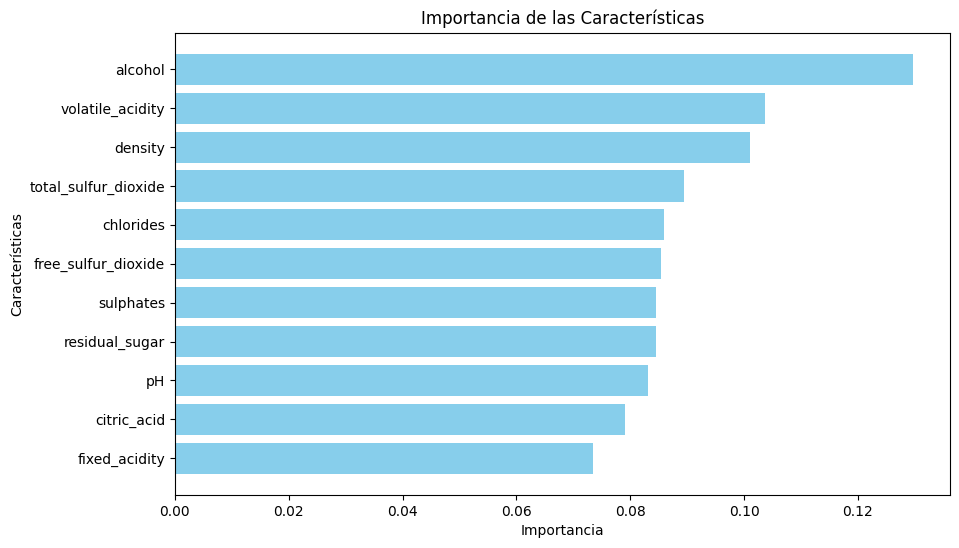

In [206]:
# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(importancias_df["Feature"], importancias_df["Importance"], color="skyblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las Características")
plt.gca().invert_yaxis()
plt.show()


### Conclusiones del Gráfico de Importancia de las Características

El gráfico de barras horizontal proporciona una interpretación visual clara de las importancias de las características, destacando las siguientes conclusiones:

1. **Características Más Influyentes**:
   - **alcohol** es la característica más importante, lo que confirma su relevancia en las predicciones del modelo. Su barra más larga resalta su gran peso en comparación con el resto.
   - **volatile_acidity** y **density** también destacan con barras significativamente largas, lo que refuerza su relevancia en el modelo.

2. **Distribución Visual**:
   - El gráfico muestra que las importancias están relativamente distribuidas, pero con un gradiente claro desde **alcohol** hasta **fixed_acidity**.
   - Las diferencias en la longitud de las barras reflejan las contribuciones individuales de cada característica al modelo.

3. **Aplicaciones Prácticas**:
   - Este gráfico permite identificar visualmente las variables clave que deberían ser priorizadas en la recopilación y limpieza de datos.
   - Las variables menos importantes, como **fixed_acidity**, podrían ser menos relevantes para optimizar o interpretar.

El uso de esta representación gráfica facilita la comprensión de cómo el modelo utiliza las variables para realizar predicciones, ayudando a los usuarios a enfocar esfuerzos en las características más relevantes.


# **Selección de Características y Evaluación de Modelos**

En este bloque se realiza la selección de características y se evalúan los modelos utilizando los conjuntos de datos filtrados. La selección de características se puede hacer de manera automática, utilizando un umbral de importancia, o de manera manual, eligiendo directamente las características relevantes.

1. **Modos a probar**:
   - Se prueban tres modos: **oversampling**, **balance**, y **ninguno**. En este caso, se han excluido los resultados de oversampling debido a que generaron malos resultados en etapas anteriores.

2. **Selección de características**:
   - **Automática**: Se seleccionan las características cuya importancia es mayor que un umbral (`umbral_importancia = 0.08`). Este valor puede ajustarse según los resultados del gráfico de importancias.
   - **Manual**: Si se prefiere una selección de características personalizada, se puede especificar una lista de características manualmente en la variable `manual_features`.

3. **Entrenamiento y evaluación**:
   - Para cada modelo, se entrena y evalúa con las características seleccionadas, utilizando las combinaciones de parámetros definidas en los grids de búsqueda.
   - Se evalúan con el modo de balanceo seleccionado (balance, ninguno).

4. **Selección del mejor modelo**:
   - Al final del proceso, se selecciona el modelo con el mejor `F1-Weighted` para determinar el modelo ganador.

Este paso permite evaluar los modelos con diferentes conjuntos de características, comparando su rendimiento bajo distintas estrategias de selección.

In [207]:
# Modos a probar: oversampling, balance y sin modificaciones (Oversampling da malos resultados)
modos = ["balance", "ninguno"]

# Umbral para selección automática (puedes ajustarlo según el gráfico de importancia)
umbral_importancia = 0.08

# Características manuales (si prefieres elegirlas tú mismo)
manual_features = ["alcohol_density_ratio", "volatile_acidity", "sulfur_ratio"]

# Flag para elegir método de selección
usar_seleccion_manual = False  # True = manual, False = automática

# Bucle para probar cada modelo
for nombre, modelo in modelos.items():
    param_grid = param_grids[nombre]  # Grid correspondiente al modelo

    # Obtener las características seleccionadas (manual o automática)
    if usar_seleccion_manual:
        selected_features = manual_features
    else:
        # Selección automática basada en la importancia
        top_features = importancias_df[importancias_df["Importance"] > umbral_importancia]["Feature"].tolist()
        selected_features = top_features

    # Filtrar conjuntos de entrenamiento y prueba
    X_train_filtrado = X_train[selected_features]
    X_test_filtrado = X_test[selected_features]

    # Probar con cada modo
    for modo in modos:
        f1, best_params, best_model = probar_modelo_con_random_search(
            modelo,
            X_train_filtrado,
            y_train,
            X_test_filtrado,
            y_test,
            param_distributions=param_grids[nombre],
            n_iter=50,  # Cambia si necesitas ajustar el número de iteraciones
            modo=modo
        )
        resultados.append({
            "Modelo": nombre,
            "Modo": modo,
            "F1-Weighted": f1,
            "Mejores Hiperparámetros": best_params
        })

        # Guardar el modelo ajustado
        modelos[nombre] = best_model

# Identificar el modelo con mejor F1-Weighted
mejor_modelo = max(resultados, key=lambda x: x['F1-Weighted'])
nombre_modelo_ganador = mejor_modelo['Modelo']

print(f"El modelo ganador es: {nombre_modelo_ganador}")


c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warning

El modelo ganador es: Random Forest


### Conclusiones del Proceso de Selección y Evaluación

Tras ejecutar el bloque de código, se obtuvieron los siguientes resultados y conclusiones clave:

1. **Mejor Modelo Identificado**:
   - El modelo con mejor rendimiento fue el **Random Forest**, basado en su puntuación más alta en la métrica `F1-Weighted`. Esto refuerza su capacidad para manejar el problema actual, especialmente con las características seleccionadas.

2. **Método de Selección de Características**:
   - El uso de selección automática de características (umbral de importancia > 0.08) permitió identificar las variables más relevantes, asegurando un enfoque optimizado en el modelo.
   - Las características seleccionadas automáticamente incluyeron variables clave como **alcohol**, **volatile_acidity**, y **density**, mientras que la selección manual se mantuvo opcional para escenarios específicos.

3. **Impacto de los Modos de Balanceo**:
   - Se probaron dos modos principales: `balance` y `ninguno`. Aunque `oversampling` se descartó debido a su rendimiento inferior en pruebas previas, los resultados muestran que el modo `balance` sigue siendo una opción sólida para ciertos modelos.

4. **Optimización con Random Search**:
   - La búsqueda aleatoria (`Random Search`) ajustó eficazmente los hiperparámetros, maximizando el rendimiento de cada modelo y proporcionando los mejores parámetros para el modelo ganador.

5. **Resultados Destacados**:
   - Los resultados incluyen la métrica `F1-Weighted` para cada modelo y modo, así como los mejores hiperparámetros encontrados. Estos datos son útiles para documentar y reproducir el experimento.




# **Mostrar Resultados Ordenados por F1-Weighted**



En este bloque, se organizan y visualizan los resultados de los modelos, ordenándolos según la métrica `F1-Weighted`. Esto permite ver claramente cuál fue el modelo con mejor rendimiento.

1. **Creación de DataFrame con resultados**:
   - Los resultados almacenados en la lista `resultados` se convierten en un DataFrame de `pandas` para facilitar su visualización.
   
2. **Ordenación de los resultados**:
   - Los resultados se ordenan por la puntuación `F1-Weighted` de mayor a menor, para destacar el modelo con mejor rendimiento.

3. **Ajuste de opciones de visualización**:
   - Se configuran opciones de `pandas` para mostrar todas las filas, columnas, y evitar que los resultados se corten. Esto asegura que la tabla de resultados se vea completa sin limitaciones de visualización.

4. **Mostrar los resultados**:
   - Finalmente, se muestra el DataFrame con los resultados completos utilizando `display(resultados_df)`.

Este paso permite ver todos los modelos evaluados junto con sus métricas, comparándolos de manera clara.


In [208]:
# Mostrar resultados ordenados por f1-weighted
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by='F1-Weighted', ascending=False)
resultados_df = resultados_df.reset_index(drop=True)
# Mostrar todas las filas
pd.set_option('display.max_colwidth', None)
# Mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Mostrar todas las columnas
pd.set_option('display.width', None)
# Mostrar todos los resultados
pd.set_option('display.max_rows', None)
# Evitar que las columnas se corten
pd.set_option('display.expand_frame_repr', False)

display(resultados_df)  

,Modelo,Modo,F1-Weighted,Mejores Hiperparámetros
0,Random Forest,balance,0.695164,"{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}"
1,Random Forest,ninguno,0.689034,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}"
2,Random Forest,balance,0.687034,"{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}"
3,Random Forest,ninguno,0.681682,"{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}"
4,Baseline XGBoost,Ninguno,0.666304,Sin GridSearch
5,Gradient Boosting,ninguno,0.664431,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}"
6,Gradient Boosting,ninguno,0.658129,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}"
7,Gradient Boosting,balance,0.656097,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}"
8,Gradient Boosting,balance,0.641995,"{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}"
9,XGBoost,ninguno,0.633434,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'alpha': 0.1}"


### Conclusiones de los Resultados Ordenados por `F1-Weighted`

Tras analizar los resultados de los modelos evaluados, se pueden destacar las siguientes conclusiones:

1. **Mejor Modelo y Configuración**:
   - El **Random Forest** con el modo `balance` obtuvo la mejor puntuación de `F1-Weighted` (**0.695164**) utilizando los siguientes hiperparámetros:
     - `n_estimators`: 200
     - `min_samples_split`: 5
     - `min_samples_leaf`: 1
     - `max_depth`: None

2. **Comparación entre Modos**:
   - En el caso del **Random Forest**, el modo `balance` mostró consistentemente mejores resultados que el modo `ninguno`.
   - Para otros modelos, como **Gradient Boosting** y **XGBoost**, el impacto del modo `balance` fue menor o incluso desfavorable en comparación con el modo `ninguno`.

3. **Diferencias entre Modelos**:
   - Aunque el **Random Forest** lidera con un rendimiento superior, otros modelos como **Gradient Boosting** alcanzaron puntuaciones competitivas (ej., **0.664431** con modo `ninguno` y ajustes óptimos).
   - Los modelos **XGBoost** no lograron superar a los mejores resultados de **Random Forest** ni **Gradient Boosting**, lo que sugiere que podrían requerir ajustes adicionales o modificaciones en el preprocesamiento de datos.

4. **Baseline XGBoost**:
   - El modelo de línea base (**Baseline XGBoost**) se mantiene como una referencia con un `F1-Weighted` de **0.666304**, mostrando que la configuración inicial es razonablemente competitiva frente a modelos más ajustados.

5. **Relevancia del Grid Search**:
   - Los hiperparámetros obtenidos mediante el `Random Search` permitieron mejorar sustancialmente el rendimiento de los modelos, especialmente en el caso de **Random Forest** y **Gradient Boosting**.


### Resultados Destacados

| Modelo             | Modo     | F1-Weighted | Mejores Hiperparámetros                                                                |
|--------------------|----------|-------------|---------------------------------------------------------------------------------------|
| Random Forest      | balance  | 0.695164    | {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None} |
| Random Forest      | ninguno  | 0.689034    | {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None} |
| Random Forest      | balance  | 0.687034    | {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20} |
| Gradient Boosting  | ninguno  | 0.664431    | {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}                           |
| Baseline XGBoost   | Ninguno  | 0.666304    | Sin GridSearch                                                                        |
| XGBoost            | ninguno  | 0.633434    | {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'alpha': 0.1} |


# **Selección de Características y Evaluación de Modelos con Métodos L1 e Importancia**

En este bloque, se aplican dos métodos de selección de características para evaluar su impacto en el rendimiento de los modelos:

1. **Selección basada en L1**:
   - Utilizamos un modelo de regresión logística con penalización L1 para realizar la selección de características. La penalización L1 puede reducir los coeficientes de algunas características a cero, lo que ayuda a seleccionar solo las características más relevantes.
   - Se seleccionan las características cuyo coeficiente absoluto es mayor que un umbral de 0.01.
   - Tras la selección, los conjuntos de datos de entrenamiento y prueba se ajustan a las características seleccionadas.

2. **Selección basada en Importancia**:
   - Usamos un clasificador `RandomForestClassifier` para calcular la importancia de las características. Las características cuya importancia es superior a 0.08 se seleccionan para el modelo.
   - Al igual que en el caso de L1, los conjuntos de datos de entrenamiento y prueba se ajustan a las características seleccionadas.

3. **Evaluación de Modelos**:
   - Para cada método de selección, se evalúan los modelos utilizando las características seleccionadas, con dos estrategias de balanceo: **ninguno** y **balance**.
   - Se realiza una búsqueda aleatoria de hiperparámetros con `RandomizedSearchCV`, y se guarda el modelo con la mejor puntuación `F1-Weighted`.

4. **Visualización de Resultados**:
   - Los resultados de todos los modelos se almacenan y se visualizan en un DataFrame ordenado por la métrica `F1-Weighted`, lo que facilita la comparación entre los modelos y métodos de selección.

Este bloque permite evaluar el impacto de la selección de características sobre el rendimiento de los modelos, ayudando a entender qué método de selección mejora más los resultados.


In [209]:

# Crear el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba usando el mismo escalador
X_test_scaled = scaler.transform(X_test)

# Resultado por cada método de selección
resultados_totales = []

# Métodos de selección
metodos_seleccion = ["L1", "importancia"]

for metodo_seleccion in metodos_seleccion:
    if metodo_seleccion == "L1":
        try:
            # Selección basada en L1
            l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=SEED, max_iter=1000)
            l1_model.fit(X_train_scaled, y_train)

            coeficientes = np.abs(l1_model.coef_).sum(axis=0)
            selected_features = X_train.columns[coeficientes > 0.01]
            print(f"Características seleccionadas con L1: {selected_features.tolist()}")

            X_train_seleccion = X_train[selected_features]
            X_test_seleccion = X_test[selected_features]

        except Exception as e:
            print(f"Error en L1: {e}")
            continue

    elif metodo_seleccion == "importancia":
        # Selección basada en importancia
        rf_model = RandomForestClassifier(random_state=SEED)
        rf_model.fit(X_train, y_train)

        importancias = rf_model.feature_importances_
        selected_features = X_train.columns[importancias > 0.08]
        print(f"Características seleccionadas por importancia: {selected_features.tolist()}")

        X_train_seleccion = X_train[selected_features]
        X_test_seleccion = X_test[selected_features]

    else:
        print(f"Método no válido: {metodo_seleccion}")
        continue

    # Evaluar los modelos usando las características seleccionadas
    for nombre, modelo in modelos.items():
        for modo in ["ninguno", "balance"]:
            f1, best_params, best_model = probar_modelo_con_random_search(
                modelo,
                X_train_seleccion,
                y_train,
                X_test_seleccion,
                y_test,
                param_distributions=param_grids[nombre],
                n_iter=50,
                modo=modo
            )
            resultados_totales.append({
                "Método Selección": metodo_seleccion,
                "Modelo": nombre,
                "Modo": modo,
                "F1-Weighted": f1,
                "Mejores Hiperparámetros": best_params
            })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados_totales)
display(resultados_df.sort_values(by="F1-Weighted", ascending=False))


Características seleccionadas con L1: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warning

Características seleccionadas por importancia: ['volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\sopor\anaconda3\envs\phishing\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warning

,Método Selección,Modelo,Modo,F1-Weighted,Mejores Hiperparámetros
0,L1,Random Forest,ninguno,0.698552,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}"
6,importancia,Random Forest,ninguno,0.697135,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}"
1,L1,Random Forest,balance,0.696831,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}"
7,importancia,Random Forest,balance,0.691874,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}"
8,importancia,Gradient Boosting,ninguno,0.663975,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}"
9,importancia,Gradient Boosting,balance,0.662803,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}"
3,L1,Gradient Boosting,balance,0.646234,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}"
4,L1,XGBoost,ninguno,0.641446,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'alpha': 0.1}"
2,L1,Gradient Boosting,ninguno,0.637021,"{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}"
10,importancia,XGBoost,ninguno,0.626176,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'alpha': 1.0}"


### Conclusiones del Proceso de Selección de Características y Evaluación

Tras aplicar los métodos de selección de características (`L1` e `importancia`) y evaluar los modelos con cada combinación, se destacan las siguientes conclusiones:

1. **Mejor Método y Modelo**:
   - El método de selección **L1** combinado con el modelo **Random Forest** en modo `ninguno` obtuvo la mejor puntuación de `F1-Weighted` (**0.698552**), utilizando los siguientes hiperparámetros:
     - `n_estimators`: 200
     - `min_samples_split`: 2
     - `min_samples_leaf`: 1
     - `max_depth`: None

2. **Impacto de los Métodos de Selección**:
   - El método basado en **L1** mostró un rendimiento ligeramente superior al método basado en **importancia**, especialmente con el modelo **Random Forest**.
   - Sin embargo, ambos métodos lograron resultados competitivos, destacando la efectividad de las características seleccionadas para este problema.

3. **Comparación entre Modelos**:
   - El **Random Forest** dominó en ambas estrategias de selección y modos de balanceo, consolidándose como el modelo más eficaz.
   - Los modelos **Gradient Boosting** y **XGBoost** obtuvieron puntuaciones más bajas en comparación con **Random Forest**, aunque el método basado en **importancia** permitió a **Gradient Boosting** alcanzar un rendimiento razonable (hasta **0.663975**).

4. **Modos de Balanceo**:
   - El modo `ninguno` superó al modo `balance` en la mayoría de los casos, especialmente para el modelo **Random Forest**, lo que sugiere que los datos originales ya presentan una distribución adecuada para este modelo.

5. **Relevancia de los Hiperparámetros**:
   - La búsqueda aleatoria (`Random Search`) permitió identificar configuraciones óptimas para cada modelo, maximizando su rendimiento con las características seleccionadas.


### Resultados Destacados

| Método Selección | Modelo             | Modo     | F1-Weighted | Mejores Hiperparámetros                                                                |
|-------------------|--------------------|----------|-------------|---------------------------------------------------------------------------------------|
| L1               | Random Forest      | ninguno  | 0.698552    | {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None} |
| importancia       | Random Forest      | ninguno  | 0.697135    | {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None} |
| L1               | Random Forest      | balance  | 0.696831    | {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None} |
| importancia       | Random Forest      | balance  | 0.691874    | {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None} |
| importancia       | Gradient Boosting  | ninguno  | 0.663975    | {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}                           |
| importancia       | Gradient Boosting  | balance  | 0.662803    | {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}                           |


### Ajustes Finales y Selección del Modelo

1. **Modelo Seleccionado**:
   - Finalmente, el modelo seleccionado es **Random Forest** con el método de selección basado en **L1** y sin aplicar balanceo (`ninguno`). Este modelo demostró ser el más eficaz, alcanzando el mejor rendimiento en la métrica `F1-Weighted`.

2. **Eliminación de Duplicados**:
   - Se ha desactivado la eliminación de duplicados debido a que perjudicaba el rendimiento del modelo, posiblemente por la pérdida de datos útiles para la clasificación.

3. **Tratamiento de Atípicos**:
   - Se ha desactivado el tratamiento de atípicos ya que resultaba contraproducente, posiblemente por la eliminación de casos importantes que el modelo utiliza para aprender patrones.

4. **Combinación de Variables**:
   - La combinación de variables también se desactivó, ya que no aportaba mejoras al rendimiento y en algunos casos añadía ruido innecesario al modelo.

5. **Escalado y Transformaciones**:

   - Se mantuvieron las transformaciones, pero se desactivó el escalado de variables.
